Welcome to Day 4 of the Practicals !!

Today we will investicate how to study sequences of behaviours. In perticular, how to use Markov Chains (MCs) and Hidden Markov Models (HMMs) to analyse the statistics of how zebrafish reorient themselves during free swim.

The data we will be using comes from the paper : [Thermal modulation of Zebrafish exploratory statistics reveals constraints on individual behavioral variability, Le Goc et al. 2021, BMC Biol \[1\]](https://bmcbiol.biomedcentral.com/articles/10.1186/s12915-021-01126-w). In this paper, the authors analyse the statiscs of how larvae re-orient themselves depending on the temperature of the water. As you might know, zebrafish larvae move in sequences of discrete bouts. With each bout, the larvae will move forward and potentially re-orient themselves. We want to understand this re-orientation statistics.

![Setup](https://raw.githubusercontent.com/EmeEmu/IBIO-Banyuls2023-Python/main/img/free_swim_setup.png)

![Convention](https://raw.githubusercontent.com/EmeEmu/IBIO-Banyuls2023-Python/main/img/free_swim_convention.png)

We will not reproduce the same analysis as [1], but simplify the basic ideas.

If you want to read more you can also look at [From behavior to circuit modeling of light-seeking navigation in zebrafish larvae, Karpenko et al. 2020, eLife \[2\]]( https://doi.org/10.7554/eLife.52882 ).


During this tutorial, we will use the following markers :
- ➡️👤⌨️ : shows you what/were you need to code yourself.
- 💡 : shows hints to help you if you need it.
- ❗ : shows important notes.
- ⚠️ : shows warnings.

❗ We remind you that at any time, you can run `?thing` to get the documentation for `thing`. Typicaly, this is useful if `thing` is a function, and you need to know what are its parameters and/or what it does.

# 0.0. Setup Colab

In [ ]:
!mkdir /content/Helper_Functions/
!wget -P /content/Helper_Functions/ https://raw.githubusercontent.com/EmeEmu/IBIO-Banyuls2023-Python/main/Helper_Functions/accessing_data.py
!wget -P /content/Helper_Functions/ https://raw.githubusercontent.com/EmeEmu/IBIO-Banyuls2023-Python/main/Helper_Functions/hmm_plotters.py
!wget -P /content/Helper_Functions/ https://raw.githubusercontent.com/EmeEmu/IBIO-Banyuls2023-Python/main/Helper_Functions/OrthoViewer.py

In [ ]:
!pip install hmmlearn

In [ ]:
!pip install ipympl
from google.colab import output
output.enable_custom_widget_manager()
%matplotlib widget

In [ ]:
!gdown --folder 1k21VhLoonOnoxxXyswrmE45VIB4FF00n

# 0.1. Imports

As usual lets start by importing a few librairies and functions

In [2]:
import h5py
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.widgets import Slider
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from hmmlearn import hmm
from tqdm import tqdm

In [3]:
from Helper_Functions.accessing_data import h5tree_view
from Helper_Functions.hmm_plotters import cmap_states, plot_transition_matrix, plot_angle_sequence

# 0.2. Get the data

And now lets load the data.

You will find it in the hdf5 file `banyuls_data/behaviour_free_swimming.h5`. Let's load this file and show the data tree. You will see that it is split into 6 different temperature conditions (18°C → 33°C).

For each temperature, you have access to different datasets :
- `bouttime` : the time of each bout.
- `displacements` : the size of each bout.
- `dtheta` : the change in orientation/direction of this bout.
- `interboutintervals` : the time between bouts (i.e. how long the larva spent not moving).
- `xpos` : the X position of the larvae
- `ypos` : the Y position of the larvae

Each of those datasets is 2D and structured `sequence x bout`. For example for 18°C, 532 trajectories were recorded, containing 642 bouts. ⚠️ However, not all 532 trajectories were imaged long enough to observe 642 bouts! Sometimes the fish get out of the field of view. So the 6 datasets mentioned above contain NaNs !! Be careful during this practical, and remember to deal with the NaNs appropriatly !

In [4]:
filename = "content/banyuls_data/behaviour_free_swimming.h5"
file = h5py.File(filename, "r")
h5tree_view(file)

. content/banyuls_data/behaviour_free_swimming.h5
├── 📁behaviour
│   ├── 🏷️framerate = `24.935128768196524`
│   └── 🏷️source = `https://bmcbiol.biomedcentral.com/articles/10.1186/s12915-021-01126-w`
│   ├── 📁18
│   │   └── 🏷️temperature = `18°C`
│   │   ├── 🔢bouttime ⚙️(532, 642)float64
│   │   │   └── 🏷️unit = `s`
│   │   ├── 🔢displacements ⚙️(532, 641)float64
│   │   │   └── 🏷️unit = `mm`
│   │   ├── 🔢dtheta ⚙️(532, 641)float64
│   │   │   └── 🏷️unit = `degree`
│   │   ├── 🔢interboutintervals ⚙️(532, 641)float64
│   │   │   └── 🏷️unit = `s`
│   │   ├── 🔢xpos ⚙️(532, 642)float64
│   │   │   └── 🏷️unit = `mm`
│   │   ├── 🔢ypos ⚙️(532, 642)float64
│   │   │   └── 🏷️unit = `mm`
│   ├── 📁22
│   │   └── 🏷️temperature = `22°C`
│   │   ├── 🔢bouttime ⚙️(1329, 749)float64
│   │   │   └── 🏷️unit = `s`
│   │   ├── 🔢displacements ⚙️(1329, 748)float64
│   │   │   └── 🏷️unit = `mm`
│   │   ├── 🔢dtheta ⚙️(1329, 748)float64
│   │   │   └── 🏷️unit = `degree`
│   │   ├── 🔢interboutintervals ⚙️(1329, 74

# 0.3. Observe the Data

Lets first focus on the data at 26°C. Let's first load the data and plot an example fish trajectory.

In [5]:
# ➡️👤⌨️
data = file["/behaviour/26/"]

xs, ys = data["xpos"][:], data["ypos"]  # x and y positions 
dthetas = data["dtheta"][:]             # reorientation angles
dts = data["interboutintervals"][:]     # interbout intervals
distance = data["displacements"][:]     # distance traveled with each bout

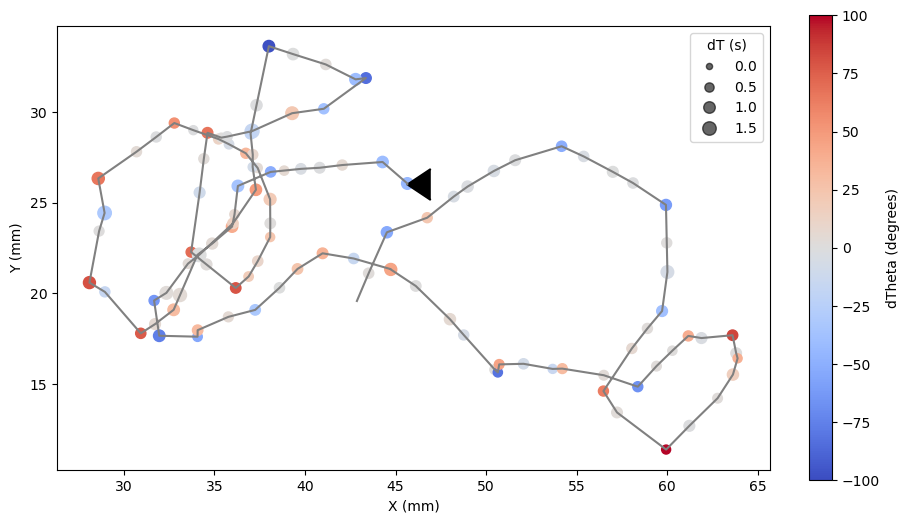

In [6]:
i = 1
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(xs[i], ys[i], color="grey")
h = ax.scatter(
    xs[i], ys[i], c=np.insert(dthetas[i],-1,0), 
    s=np.insert(np.nan_to_num(dts[i]), 0, 0)*50+20,
    cmap="coolwarm", vmin=-100, vmax=+100)
ax.scatter(xs[i,0], ys[i,0], marker=4, s=500, color="k")

fig.colorbar(h, ax=ax, label="dTheta (degrees)", fraction=0.03)
handles, labels = h.legend_elements(prop="sizes", alpha=0.6, num=5, func=lambda x: (x-20)/50)
legend2 = ax.legend(handles, labels, loc="upper right", title="dT (s)")

ax.set_xlabel("X (mm)")
ax.set_ylabel("Y (mm)")
ax.set_aspect("equal")

Look at a few trajactories by changing `i` in the previous cell. Do you understand how the larvae choose to reorient themselves ?

# 1. Markov Chains

In the first part of this practical, we will :
1. manualy classify bouts to be one of 3 states : 'forward', 'left' or 'right'
2. find the Markovian statistics of those 3 states
3. see how those statistics evolve with temperature
4. find the stationary distribution of the Markov Chain
5. use the Markov Chain to generate new sequences of states 

## 1.1 Classifying Bouts

Let's start by looking at the re-orientation angles. Every time the larvae make a bout, they reorient their body by a certain angle $\delta \theta$.
- if $\delta \theta \approx 0$ : they will essentialy be going forward.
- if $\delta \theta < 0$ : they will be going left.
- if $\delta \theta > 0$ : they will be going right.

Run the following cell to plot the histogram of $\delta \theta$. **➡️👤⌨️Using the two sliders, can you find two thresholds which will define the 3 states : 'forward', 'left' and 'right' ?➡️👤⌨️**

0

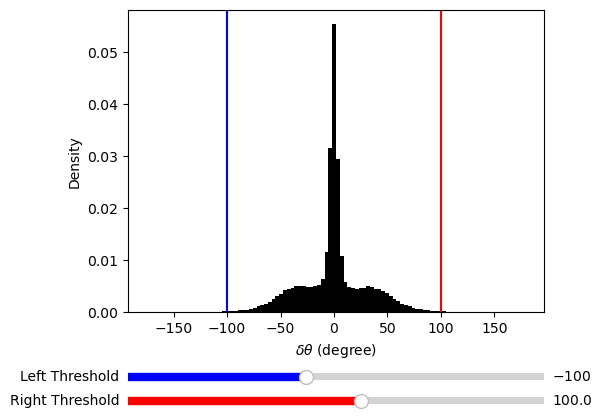

In [5]:
fig, ax = plt.subplots()
ax.hist(dthetas.ravel(), bins=100, color="k", density=True);
left_line = ax.axvline(-100, color=cmap_states.colors[1])
right_line = ax.axvline(+100, color=cmap_states.colors[2])
ax.set_xlabel(r"$\delta \theta$ (degree)")
ax.set_ylabel("Density")

fig.subplots_adjust(left=0.25, bottom=0.25)
# Make a horizontal slider to control the frequency.
axslidL = fig.add_axes([0.25, 0.1, 0.65, 0.03])
left_slider = Slider(
    ax=axslidL,
    label='Left Threshold',
    valmin=np.nanmin(dthetas),
    valmax=0,
    valinit=-100,
    color=cmap_states.colors[1]
)
axslidR = fig.add_axes([0.25, 0.05, 0.65, 0.03])
right_slider = Slider(
    ax=axslidR,
    label='Right Threshold',
    valmax=np.nanmax(dthetas),
    valmin=0,
    valinit=+100,
    color=cmap_states.colors[2]
)

def update(val):
    left_line.set_xdata([left_slider.val])
    right_line.set_xdata([right_slider.val])
    fig.canvas.draw_idle()

left_slider.on_changed(update)
right_slider.on_changed(update)

In [8]:
# ➡️👤⌨️
left, right = -10, +10 # the two thresholds you found

➡️👤⌨️Now lets **write a function to classify bouts according to the thresholds.** ➡️👤⌨️

It should take $\delta \theta$s as argument and return :
- 0 for 'forward'
- 1 for 'left'
- 2 for 'right'

In [9]:
def bout_classifier(dtheta_seqs, left_threshold, right_threshold):
    """Classify re-orientation angles into 3 states based on 2 thresholds.

    Re-orientation angle δθ are classifed as followed :
        - δθ < :left_threshold:  → 1
        - δθ > :right_threshold: → 2
        - :left_threshold: < δθ < :right_threshold: → 0
        - δθ = NaN → -1
    ⚠️ Be carefull of the NaNs !! 
    
    Parameters :
    ------------
    dtheta_seqs : array
        sequences of re-orientation angles
    left_threshold : number
        lower threshold
    right_threshold : number
        upper threshold

    Returns :
    ---------
    bout_seqs : array of integers
        sequence of states.
    """
    # ➡️👤⌨️
    idx_left = np.where(dtheta_seqs < left_threshold)
    idx_right = np.where(dtheta_seqs > right_threshold)
    bout_seqs = np.zeros_like(dtheta_seqs, dtype=np.int8)
    bout_seqs[idx_left] = 1
    bout_seqs[idx_right] = 2
    bout_seqs[~np.isfinite(dtheta_seqs)] = -1
    # ➡️👤⌨️

    assert bout_seqs.shape == dtheta_seqs.shape, ":bout_seqs: should have the same shape as :dtheta_seqs:."
    assert "int" in bout_seqs.dtype.name, ":bout_seqs: should be an array of integers."
    return bout_seqs

➡️👤⌨️ Let's **apply your classification function to the data** ➡️👤⌨️

In [10]:
# ➡️👤⌨️
bouts = bout_classifier(dthetas, left, right)

Now, let's plot the histograms of re-orientation angles for each state to check that our classification worked.

Text(0, 0.5, 'Density')

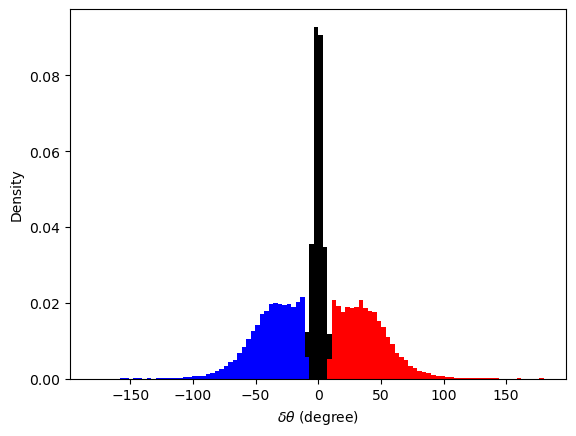

In [9]:
fig, ax = plt.subplots()
for s in range(3):
    ax.hist(dthetas[bouts==s], bins=100, range=[-180, +180],density=True, color=cmap_states.colors[s]);
ax.set_xlabel(r"$\delta \theta$ (degree)")
ax.set_ylabel("Density")

And let's see what it looks like for an example sequence

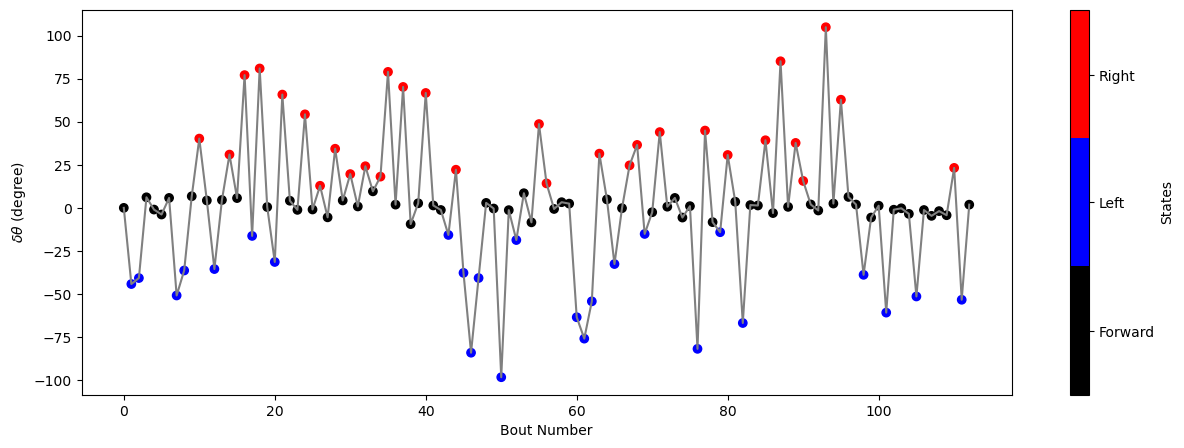

In [11]:
i=1
fig, ax = plt.subplots(figsize=(15,5))
plot_angle_sequence(ax, dthetas[i], states=bouts[i])

## 1.2 Bout Probabilities and transitions

Now that we have classifed the bouts into 3 possible states, we can define a Markov Chain to study the statistics of those states and the transitions between those states.

**A quick reminder on Markov Chains (MCs)** 

The idea of a MC is that the next state is only determined from the current state. This is done through the Transition Matrix which gives you the probabilities of all possible next states, given the current state. So in effect, it is a system which has no memory.  
In this tutorial, we will write the probability of the next state given the current state as : $P(\text{next}|\text{current}) = P(\text{current}→\text{next}) = P(c→n)$

![Markov](https://raw.githubusercontent.com/EmeEmu/IBIO-Banyuls2023-Python/main/img/Markov.png)

➡️👤⌨️ We will start by first **creating a function which computes the *a priori* probability of each state from the data** ➡️👤⌨️ : $$P(s)\ ,\ s\in{F,L,R}$$

In [12]:
def bout_proba(bout_seqs):
    """Compute the a priori probability of each state.

    💡 you can use the function np.unique(X, return_counts=True) to count 
    the occurence of every unique item in an array.

    ⚠️ the input might contain values -1 (remember the previous exercise). 
    Your function should work with and without those -1 values !
    
    Parameters :
    ------------
    bout_seqs : array of integers
        sequence of states. 0='Forward', 1='Left', 2='Right', -1=NaN

    Returns :
    ---------
    p_bout : array of 3 float
        probability of each state 'Forward', 'Left', 'Right'
    """
    # ➡️👤⌨️
    types, count = np.unique(bout_seqs, return_counts=True)
    if -1 in types:
        n_bout = count[1:]
    else:
        n_bout = count
    n_tot = n_bout.sum()
    p_bout = n_bout/n_tot
    # ➡️👤⌨️
    
    assert p_bout.ndim == 1, ":p_bout: should be a 1d array with 3 floats."
    assert len(p_bout)==3, ":p_bout: should be a 1d array with 3 floats."
    assert p_bout.sum() == 1, ":p_bout: is a probability array. It should be normalised to 1."
    return p_bout

➡️👤⌨️ **Let's apply this function to our sequence of bouts to see the $P(s)$** ➡️👤⌨️

In [13]:
# ➡️👤⌨️
p_bouts = bout_proba(bouts)
p_bouts

array([0.50496375, 0.25018405, 0.2448522 ])

As $P(s)$ is the *a priori* probability of being in each state, $\sum_{s\in{F,L,R}}P(s)=1$. **➡️👤⌨️ Check that this is true of `p_bouts` ➡️👤⌨️**

In [14]:
# ➡️👤⌨️
p_bouts.sum() == 1

True

➡️👤⌨️ Now we will **create a function to compute the Transition Probability Matrix.** ➡️👤⌨️

This is a bit more complicated than $P(s)$.

In [15]:
def bout_transition(bout_seqs):
    """Compute the transition probability matrix from sequences of bouts.

    💡 you need to look at each sequence one by one. For each bout, identify
    the next bout, this gives you the transition, and record the total 
    number of times you have seen each transition. You will then need to
    normalise the matrix correctly.

    ⚠️ the input might contain values -1 (remember the previous exercise). 
    Your function should work with and without those -1 values !
    
    Parameters :
    ------------
    bout_seqs : 2D array of integers, shape (sequence x bouts)
        sequences of states. 0='Forward', 1='Left', 2='Right', -1=NaN

    Returns :
    ---------
    P : 2D array of shape (3,3)
        probability of transition between each state 'Forward', 'Left' and 'Right'.
    """
    # ➡️👤⌨️
    T = np.zeros((3,3), dtype=np.int_)
    for s,seq in enumerate(bout_seqs):
        for i in range(len(seq)-1):
            j = i+1
            if seq[j] == -1:
                break
            T[seq[i], seq[j]] += 1
    P = T / T.sum(axis=1)[:,np.newaxis]
    # ➡️👤⌨️
    
    assert P.shape == (3,3), ":P: should be a 2D matrix of shape 3x3."
    assert np.isclose(P.sum(axis=1), 1).all(), ":P: is not normalised properly."
    return P

**➡️👤⌨️ Let's apply this function to our sequence of bouts ➡️👤⌨️**

In [16]:
# ➡️👤⌨️
T_bouts = bout_transition(bouts)
T_bouts

array([[0.48783171, 0.25741996, 0.25474833],
       [0.51556403, 0.31468373, 0.16975225],
       [0.52419168, 0.17214826, 0.30366006]])

As the transition matrix gives you the probability of going to the next state $n$ from the current state $c$ : $P(c→n)$, it should have the following normalisation : $$\sum_{n\in{F,L,R}}P(c→n)=1\ \ \forall c$$
**➡️👤⌨️ Check that this is the case for `T_bouts` ➡️👤⌨️**

In [17]:
# ➡️👤⌨️
(T_bouts.sum(axis=1)==1).all()

True

Now that was had work ! 😮‍💨😮‍💨  Well Done !! 😃 

As a reward, here is a plot of what we have found so far : 

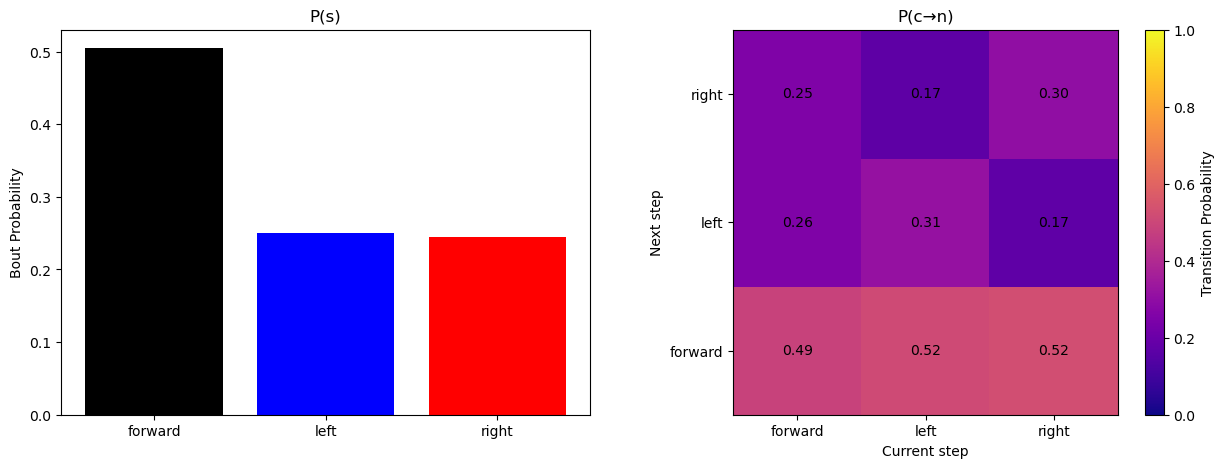

In [18]:
fig, axs = plt.subplots(ncols=2, figsize=(15,5))

ax = axs[0]
ax.set_title(r"P(s)")
ax.bar([0,1,2], p_bouts, color=cmap_states.colors)
ax.set_xticks([0,1,2], ["forward", "left", "right"])
ax.set_ylabel("Bout Probability")


ax = axs[1]
ax.set_title(r"P(c→n)")
h = plot_transition_matrix(ax, T_bouts)
fig.colorbar(h, ax=ax, label="Transition Probability")

Spend a bit of time interpreting those 2 graphs. What do they tell you about the re-orientation dynamics of the larvae ?

## 1.3 Comparing Different temperatures

Now that we have seen how to :
- classify the bouts
- compute $P(s)$
- compute $P(c→n)$

for the dataset at 26°C, we will do the same for the other temperatures.

In [19]:
Temperatures = [18,22,26,30,33]

**➡️👤⌨️ Use the 3 function you wrote earlier to compute $P(s)$ and $P(c→n)$ for each temperature. ➡️👤⌨️**

Store the results in 2 array :
- `p_alltemp` of shape (temperatures x 3)
- `T_alltemp` of shape (temperatures x 3 x 3)

In [20]:
# ➡️👤⌨️
p_alltemp = np.empty((len(Temperatures), 3))
T_alltemp = np.empty((len(Temperatures), 3, 3))
for t,T in enumerate(Temperatures):
    dthetas = file[f"/behaviour/{T}/dtheta"][:]
    bouts = bout_classifier(dthetas, left, right)
    p_alltemp[t] = bout_proba(bouts)
    T_alltemp[t] = bout_transition(bouts)

Now we will plot how $P(s)$ varies with temperature

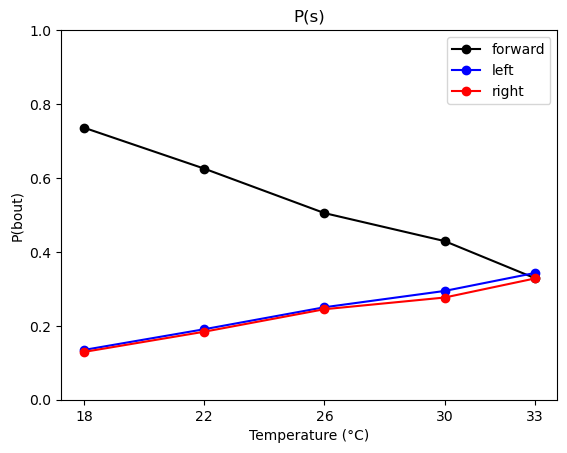

In [21]:
fig, ax = plt.subplots()
ax.plot(Temperatures, p_alltemp[:,0], "-o", color=cmap_states.colors[0], label="forward")
ax.plot(Temperatures, p_alltemp[:,1], "-o", color=cmap_states.colors[1], label="left")
ax.plot(Temperatures, p_alltemp[:,2], "-o", color=cmap_states.colors[2], label="right")
ax.set_ylim(0,1)
ax.set_xticks(Temperatures)
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("P(bout)")
ax.set_title(r"P(s)")
ax.legend()

And now how $P(c→n)$ varies with temperature.

Text(0.5, 1.0, 'P(c→n)')

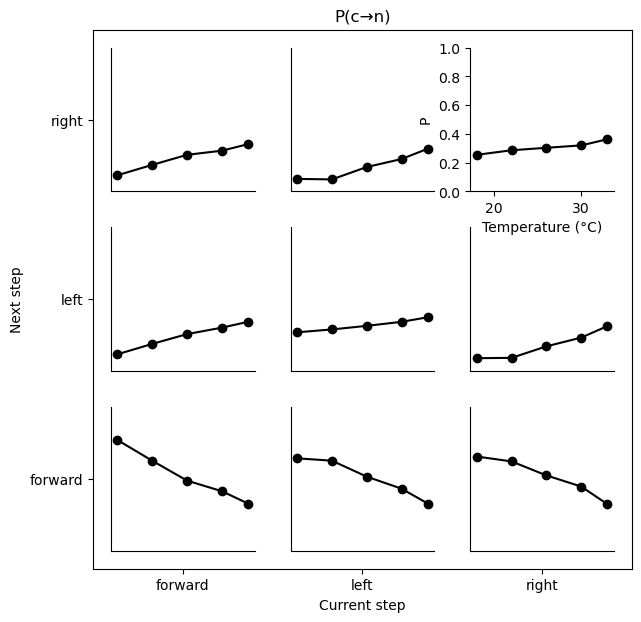

In [138]:
fig, ax = plt.subplots(figsize=(7,7))
for i in range(3):
    for j in range(3):
        axin = ax.inset_axes([i-0.4, j-0.4, 0.8, 0.8], transform=ax.transData)
        if (i,j) != (2,2):
            axin.set_xticks([])
            axin.set_yticks([])
        else:
            axin.set_xlabel("Temperature (°C)")
            axin.set_ylabel("P")
        axin.spines['right'].set_visible(False)
        axin.spines['top'].set_visible(False)
        axin.set_ylim(0,1)
        axin.plot(Temperatures, T_alltemp[:,i,j], "-o",color="k")
        
ax.set_xticks([0,1,2], ["forward", "left", "right"])
ax.set_yticks([0,1,2], ["forward", "left", "right"])
ax.set_xlabel("Current step")
ax.set_ylabel("Next step")
ax.set_xlim(-0.5,2.5)
ax.set_ylim(-0.5,2.5)
ax.set_aspect("equal")
ax.set_title(r"P(c→n)")

How do you interpret those results ? What does this mean for the larvae behaviour ?

## 1.4 Stationary Distriution

An important property of a Markov Chain is its stationary distribution $\pi_s$. In this section we will compute it using 2 different methods, and compare it to the $P(s)$ we computed from the data.

**First lets have a quick reminder about Stationary Distributions (SDs) :**

The SD of a MC can be seen as the steady state regime of that MC. It is the probability of states $\pi = [P(s_1), ..., P(s_n)] = [\pi_{s_1}, ...\pi_{s_n}]$ which will not change given the transition matrix $T_{cn}=P(c→n)$. Mathematicaly this is expressed as $$\pi T = \pi$$

**Why is it useful to know $\pi_s$ ?**  
Well it tells you that, whatever your initial state, over the long run, the Markov Chain will be in state $s$ with a probability $\pi_s$.

**How do you find $\pi_s$ ?**  
There are 2 methods :
1. solve the equation $\pi T = \pi$ to find $\pi$. This will give you a quasi-exact solution, but can be quite math-intensive
2. by mutiplying $T$ with itself $n$ times, you are computing the transition probability from the current step to n steps in the future $T^n = T\times T\times...\times T$. It can be shown that when $n→\infty$, $T^n_c = \pi\ \ \forall c$.

Don't worry if this is not clear yet, we will use both methods down bellow and you will understand.

Lets start with method 1. solving $\pi T = \pi$

In [23]:
eigenvals, eigenvects = np.linalg.eig(T_bouts.T)      # find eigen of matrix

In [24]:
close_to_1_idx = np.isclose(eigenvals,1)              # find the eigen value which is close to 1
target_eigenvect = eigenvects[:,close_to_1_idx][:,0]  # find the respective eigen vector

In [25]:
pi_1 = target_eigenvect / sum(target_eigenvect)       # normalise the eigen vector vector to get a probability
pi_1

array([0.50371241, 0.25085664, 0.24543095])

➡️👤⌨️ now **check that `pi_1` is indeed a stationary distribution of `T_bouts` ➡️👤⌨️**

💡 To check that $\pi T = \pi$, you can check that $\pi T - \pi \approx \vec{0}$ .  
💡 $\pi T$ requires a matrix multiplication which can be made with the numpy `@` operator.

In [26]:
# ➡️👤⌨️
pi_1@T_bouts - pi_1

array([-1.11022302e-16,  0.00000000e+00,  5.55111512e-17])

Now let's try method 2 :  
**➡️👤⌨️ Compute $T^n$ ➡️👤⌨️**

💡 you can use the function `np.linalg.matrix_power` to raise a array to a power

In [27]:
# ➡️👤⌨️
T_power = np.linalg.matrix_power(T_bouts,30)

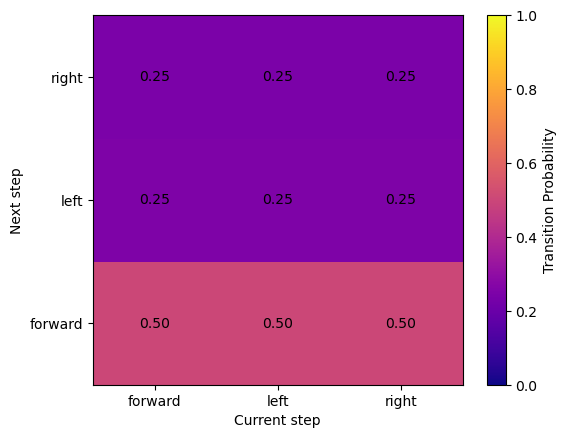

In [28]:
fig, ax = plt.subplots()
h = plot_transition_matrix(ax, T_power)
fig.colorbar(h, ax=ax, label="Transition Probability")

As you can see, if you choose $n$ big enoug all the columns of `T_power` are the same.  
**➡️👤⌨️ Isolate one column as `pi_2` and check that it is indeed a stationary distribution of `T_bouts` ➡️👤⌨️**

In [29]:
# ➡️👤⌨️
pi_2 = T_power[0]
pi_2

array([0.50371241, 0.25085664, 0.24543095])

In [30]:
# ➡️👤⌨️
pi_2@T_bouts - pi_2

array([ 0.00000000e+00, -5.55111512e-17,  2.77555756e-17])

➡️👤⌨️ Now **compare `pi_1`, `pi_2` and `p_bouts`. What can you conclude ? ➡️👤⌨️**

In [31]:
pi_1

array([0.50371241, 0.25085664, 0.24543095])

In [32]:
pi_2

array([0.50371241, 0.25085664, 0.24543095])

In [33]:
p_bouts

array([0.50496375, 0.25018405, 0.2448522 ])

In [34]:
p_bouts@T_bouts - p_bouts

array([-0.00129104,  0.00068343,  0.00060761])

## 1.5 Generate a sequence of bouts

An important aspect of Markov Chains is that they are generative models. Indeed, once you know the transition matrix $T_{cn} = P(c→n)\ \ c,n\in \{F,L,R\}$, you can perform the follwing algorithm to generate a sequence of states :
1. choose an initial state $s_1$
2. from $T_{cn}$ find $P(s_1→n)$ the probabilities of transitioning to each state from $s_1$
3. find the next state $s_2 \sim P(s_1→n)$ by sampling $P(s_1→n)$
4. repeat 2. and 3. to find $P(s_2→n)$ and $s_3 \sim P(s_2→n)$
5. ... do that N-1 times
6. you have generated a sequence of states $[s_1, s_2, ..., s_N]$

❗**Notes :**  
- $T_{cn}$ is a matrix (it is 2D), but $P(s_1→n)$ is a vector (it is 1D). It's the column $s_1$ of $T$.  
- $P(s_1→n)$ is a probability vector, so it is normalised $\sum_{n\in \{F,L,R\}}P(s_1→n) = 1$
- We can sample a state from any probability vector. For example, to choose the initial state $s_1$, it is common practice to sample from the *a priori* state probability $P(s)$ with $s_1 \sim P(s)$.

In our case, we know the transition matrix `T_bouts` between the states 'Forward', 'Left' and 'Right', and we will now use it to generate fake behavioural sequences of re-orientations.

➡️👤⌨️ To start, we will first **write a function which performs the sampling from any probability vector ➡️👤⌨️**.

In [35]:
def rand_state_from_proba(p, n=None):
    """Sample a probability vector.

    💡 You can use the function np.random.choice to perform the sampling.

    Parameters :
    ------------
    p : 1d array
        probability vector
    n : interger or None
        number of samples to make. If None, will sample only once.
        default : None

    Return :
    --------
    s : 1d array or interger
        sampled state(s)
    """
    assert p.ndim==1, ":p: should be a 1D vector."
    assert p.sum()==1, ":p: should be normalised to 1."
    
    # ➡️👤⌨️
    possibilities = np.arange(len(p))
    s = np.random.choice(possibilities, p=p, size=n)
    # ➡️👤⌨️

    if n is None:
        assert "int" in str(type(s)), ":n:=None therefore :s: should be an integer."
    else:
        assert s.ndim==1, ":s: should be a 1D vector."
        assert len(s)==n, ":s: should be of lenght :n:."
    return s

Now let's check that, if we sample 1 million times from the *a priori* probability $P(s)$ we computed earlier `p_bouts`, we get the same fraction of each state 'Forward','Left', and 'Right'.

**➡️👤⌨️ First sample (with `n` = 1 million) the probability vector `p_bouts`. ➡️👤⌨️**

In [36]:
# ➡️👤⌨️
samples = rand_state_from_proba(p_bouts, n=1000000)
samples

array([0, 2, 2, ..., 1, 2, 1])

Now we use the `bout_proba` function we defined earlier to compute the *a priori* probability of each state in the sampled data. And we compare with `p_bouts`.  
If your function `rand_state_from_proba` function is correct, the original and sampled data should have the same *a priori* state probabilities. **Check that this is the case.**

Text(0.5, 1.0, 'P(s)')

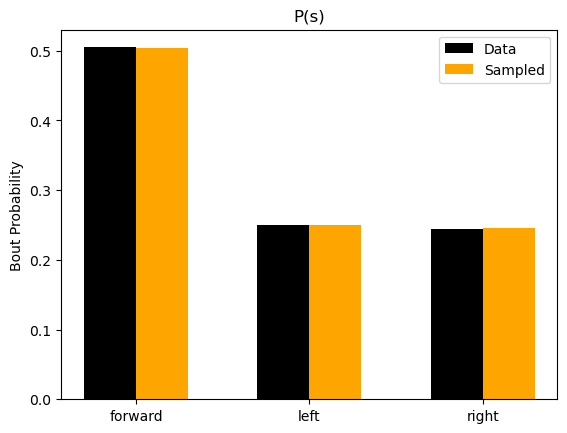

In [37]:
p_sampled = bout_proba(samples)

fig, ax = plt.subplots()
width = 0.3
x = np.arange(3)
ax.bar(x-width/2, p_bouts, width, label="Data", color="k")
ax.bar(x+width/2, p_sampled, width, label="Sampled", color="orange")
ax.legend()
ax.set_xticks([0,1,2], ["forward", "left", "right"])
ax.set_ylabel("Bout Probability")
ax.set_title(r"P(s)")

➡️👤⌨️Now that we have a way to sample from a probability vector, **write a function which implements the generation algorithm descibed above. ➡️👤⌨️**

In [38]:
def generate_sequence(N, p, T):
    """Generate a sequence from a Markov Chain.

    Parameters :
    ------------
    N : interger
        number of steps to generate.
    p : 1d array
        a priori probability vector of states.
    T : 2d array
        transition probability matrix between states.

    Return :
    --------
    seq : 1d array of ints, lenght :N:
        sequence of generated states
    """
    assert p.ndim==1, ":p: should be a 1d vector."
    assert T.ndim==2, ":T: should be a 2D matrix."
    assert len(p) == T.shape[0] == T.shape[1], ":p: and :T: have incompatible shapes."
    assert p.sum()==1, ":p: should be a normalised probability vector."
    assert (T.sum(axis=1)==1).all(), ":T: should be a properly normalised transition matrix."

    # ➡️👤⌨️
    seq = np.empty(N, dtype=np.int_)
    start = rand_state_from_proba(p)
    seq[0] = start
    for i in range(1,N):
        seq[i] = rand_state_from_proba(T[seq[i-1]])
    # ➡️👤⌨️

    assert seq.ndim==1, ":seq: should be a 1d vector."
    assert len(seq)==N, ":seq: should have a lenght of :N:."
    assert "int" in seq.dtype.name, ":seq: should be a vector of integers."
    return seq

**➡️👤⌨️ Now use this new function to generate 10 thousand steps from `T_bouts` and `p_bouts` ➡️👤⌨️**  
Then run the new cell to check that the statistics of the generated sequence is the same as in the data.

In [39]:
# ➡️👤⌨️
sequence = generate_sequence(10000,p_bouts, T_bouts)

Text(0.5, 1.0, 'P(c→n)')

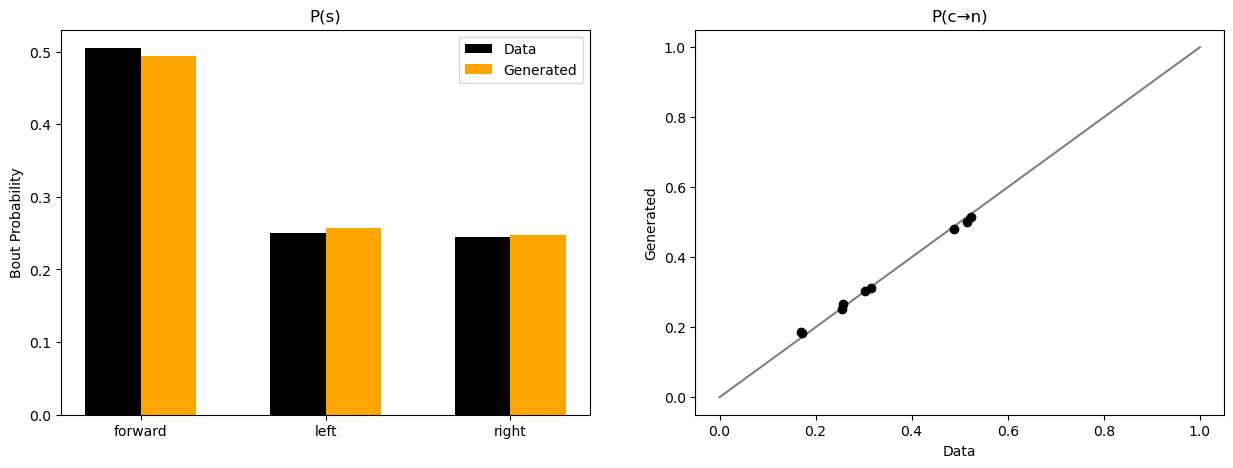

In [40]:
fig, axs = plt.subplots(ncols=2, figsize=(15,5))

ax = axs[0]
width = 0.3
x = np.arange(3)
ax.bar(x-width/2, p_bouts, width, label="Data", color="k")
ax.bar(x+width/2, bout_proba(sequence), width, label="Generated", color="orange")
ax.legend()
ax.set_xticks([0,1,2], ["forward", "left", "right"])
ax.set_ylabel("Bout Probability")
ax.set_title(r"P(s)")

ax = axs[1]
ax.plot([0,1], [0,1], color="grey", zorder=0)
ax.scatter(T_bouts, bout_transition([sequence]), color="k")
ax.set_xlabel("Data")
ax.set_ylabel("Generated")
ax.set_title(r"P(c→n)")

➡️👤⌨️ Now that we know our Markov Chain generation works, **generate a smaller number of steps and plot them to see what it looks like.** ➡️👤⌨️

In [41]:
# ➡️👤⌨️
sequence = generate_sequence(100,p_bouts, T_bouts)

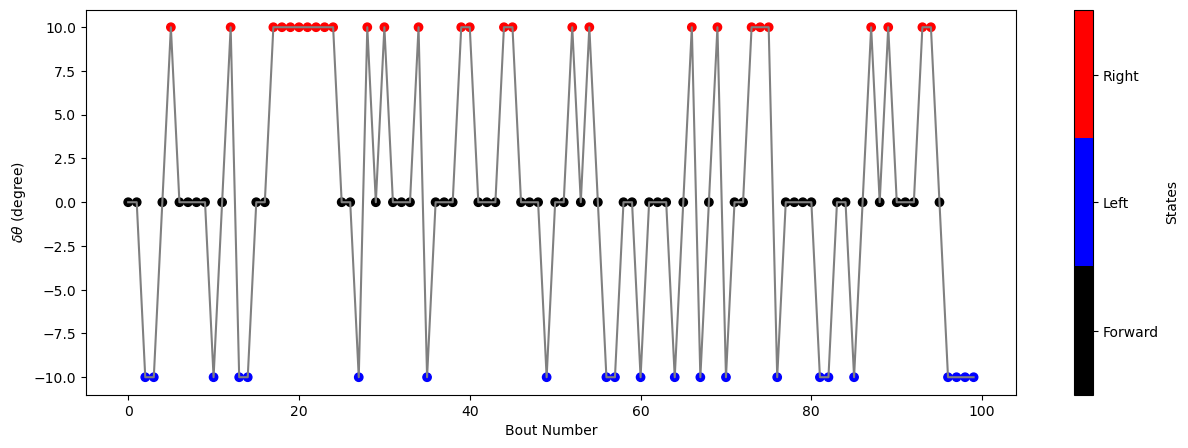

In [48]:
fig, ax = plt.subplots(figsize=(15,5))
angle = sequence.astype(float).copy()
angle[sequence==2] = right
angle[sequence==1] = left
plot_angle_sequence(ax, angle, states=sequence)

# 2. (optional) Gaussian Mixture

❗ This section is optional. If you have less than 1h left before the end of the practical, move to the [next section](#hidden-markov-model).

Previously, we classified bouts based on manual thresholds. This might be good enough in certain cases such as this one, but it has the disadvantage of being very arbitrary.  

In this section we will see a method called **Gaussian Mixture Model**.  
The idea of a Mixture Model is to identify subpopulations while only looking at the overall population. Typicaly in Gaussian Mixture Model, we make the assumption that every subpopulation follows a normal distribution $\mathcal{N(\mu,\sigma)}$.  
What is good with Mixture Models, is that they are unsupervised, therefore the choice of which observation belongs in which subpopulation is no longer arbitrary.

![GaussianMixtureModel](https://raw.githubusercontent.com/EmeEmu/IBIO-Banyuls2023-Python/main/img/Mixture.png)

First let's reload the data for 26°C.

In [49]:
data = file["/behaviour/26/"]
xs, ys = data["xpos"][:], data["ypos"]  # x and y positions 
dthetas = data["dtheta"][:]             # reorientation angles
dts = data["interboutintervals"][:]     # interbout intervals
distance = data["displacements"][:]     # distance traveled with each bout

Let's look again at the distribution of re-orientation angles, and try to use Gaussian Mixture Modeling to find our 3 states 'Forward', 'Left', and 'Right'.

Text(0, 0.5, 'Density')

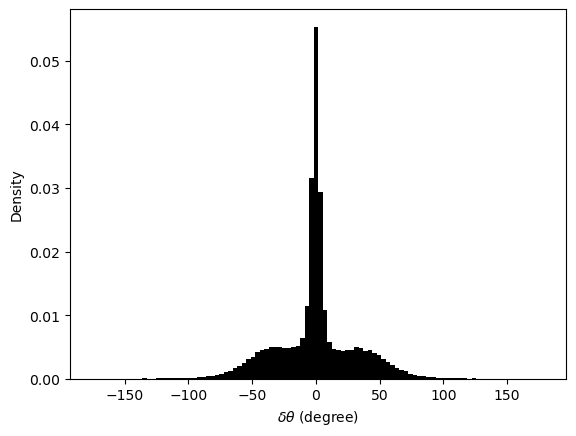

In [50]:
fig, ax = plt.subplots()
ax.hist(dthetas.ravel(), bins=100, color="k", density=True);
ax.set_xlabel(r"$\delta \theta$ (degree)")
ax.set_ylabel("Density")

It is clear here that there are 3 subpopulations, corresponding to 3 gaussian-like distributions with means $\mu \approx [0,-40,+40]$.  
We will therefore create a Gaussian Mixture Model with 3 componants (aka. subpopulations), and provide it with an initial guess of the means. We do this for 2 reasons :
1. so that the learning algorithm converges faster
2. to force the subpopulation #0 to be the 'Forward', subpopulation #1 to be the 'Left', etc ...

In [51]:
gm = GaussianMixture(n_components=3, means_init=np.array([[0],[-40],[+40]]))
gm.fit(dthetas[np.isfinite(dthetas)][:,np.newaxis])

GaussianMixture(means_init=array([[  0.],
       [-40.],
       [ 40.]]),
                n_components=3)

Let's look at what parameters were found by the model.  
first the means of the subpopulations :

In [52]:
gm.means_

array([[ -0.03557236],
       [-29.09863462],
       [ 30.41118322]])

then the variances ($=\sigma^2$) :

In [53]:
gm.covariances_

array([[[ 11.53459631]],

       [[690.54850275]],

       [[709.55355886]]])

and how much each subpopulation participates in the overall population (aka. the weights) : 

In [54]:
gm.weights_

array([0.41531934, 0.2983189 , 0.28636176])

Let's look at what those subpolulation's distributions look like :

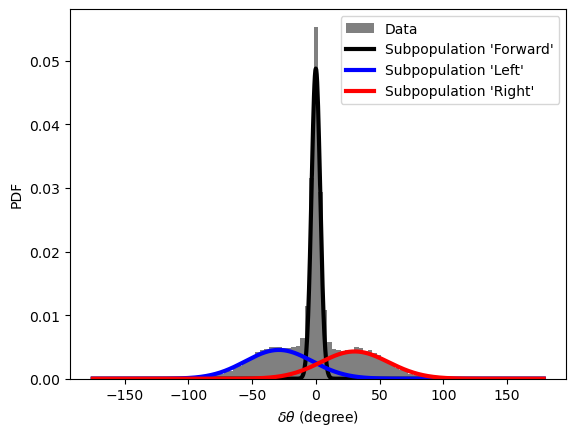

In [55]:
fig, ax = plt.subplots()
x = np.linspace(np.nanmin(dthetas), np.nanmax(dthetas), 1000)
ax.hist(dthetas.ravel(), bins=100, color="grey", density=True, stacked=False,label="Data");
ax.plot(
    x, 
    norm(loc=gm.means_[0], scale=np.sqrt(gm.covariances_[0,0])).pdf(x) * gm.weights_[0], 
    color=cmap_states.colors[0], 
    label="Subpopulation 'Forward'",
    linewidth=3,
)
ax.plot(
    x, 
    norm(loc=gm.means_[1], scale=np.sqrt(gm.covariances_[1,0])).pdf(x) * gm.weights_[1], 
    color=cmap_states.colors[1],
    label="Subpopulation 'Left'",
    linewidth=3,
)
ax.plot(
    x, 
    norm(loc=gm.means_[2], scale=np.sqrt(gm.covariances_[2,0])).pdf(x) * gm.weights_[2], 
    color=cmap_states.colors[2],
    label="Subpopulation 'Right'",
    linewidth=3,
)
ax.set_xlabel(r"$\delta \theta$ (degree)")
ax.set_ylabel("PDF")
ax.legend()

With Mixture Models, once they are trained, you can ask them to classify in which subpopulation is each observation.  
Let's first do it on all observations :

Text(0, 0.5, 'PDF')

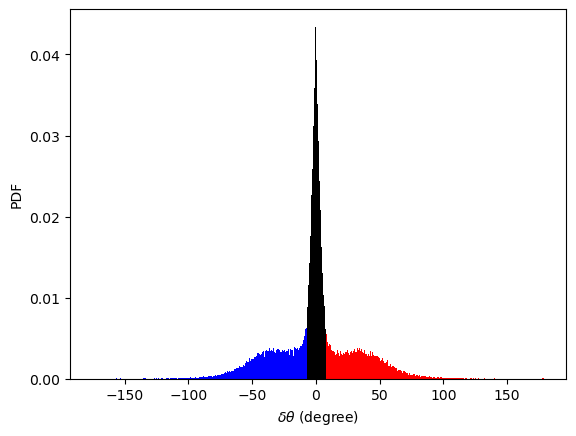

In [56]:
h, bins = np.histogram(dthetas[np.isfinite(dthetas)], bins=500)
h = h/h.sum()
predicted = gm.predict(bins[:,np.newaxis])
colors = [{p<0.5:cmap_states.colors[0], 0.5<=p<=1.5: cmap_states.colors[1], p>1.5: cmap_states.colors[2]}[True] for p in predicted]
fig, ax = plt.subplots()
ax.bar(bins[:-1], h, width=np.diff(bins), align="edge", color=colors)
ax.set_xlabel(r"$\delta \theta$ (degree)")
ax.set_ylabel("PDF")

➡️👤⌨️ **Now extract from `dthetas` a single re-orientation sequence (remember to remove the NaNs), and use the Gaussian Mixture Model to predict in which subpopulation is each observation.** ➡️👤⌨️

💡 you can use the function `gm.predict`.  
💡 `gm.predict` expects a 2D array, you can use `np.newaxis` to solve this issue.

In [57]:
# ➡️👤⌨️
sequence = dthetas[1]
sequence = sequence[np.isfinite(sequence)]
predicted_states = gm.predict(sequence[:,np.newaxis])

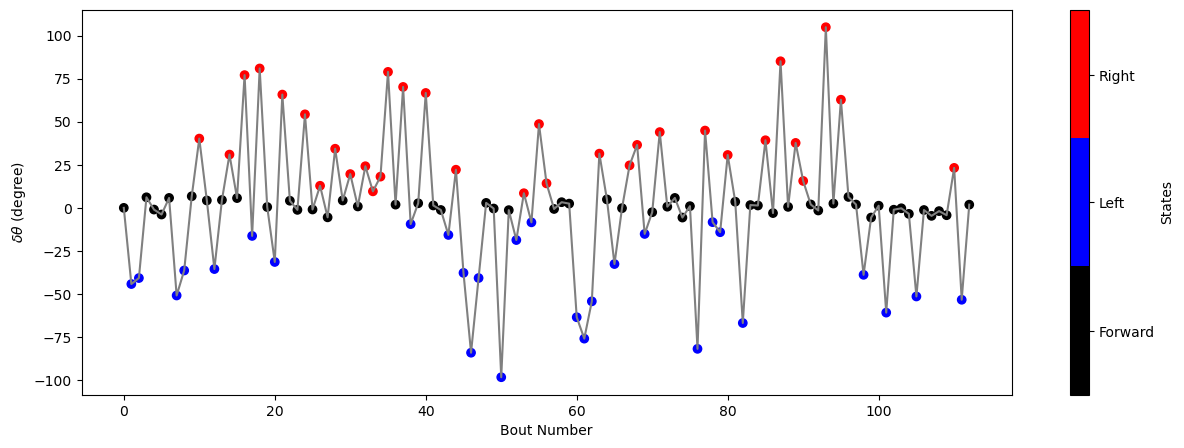

In [58]:
fig, ax = plt.subplots(figsize=(15,5))
plot_angle_sequence(ax, sequence, states=predicted_states)

Because Mixture Models are probabilistic, they can also ask for the probability for an observation to be in each subpopulation.

➡️👤⌨️ **Using the sequence as above, compute the probability that each observation is in the 'Left' subpopulation** ➡️👤⌨️

💡 you can use the `gm.predict_proba` function.

In [59]:
# ➡️👤⌨️
predicted_proba = gm.predict_proba(sequence[:,np.newaxis])
proba_left = predicted_proba[:,1]

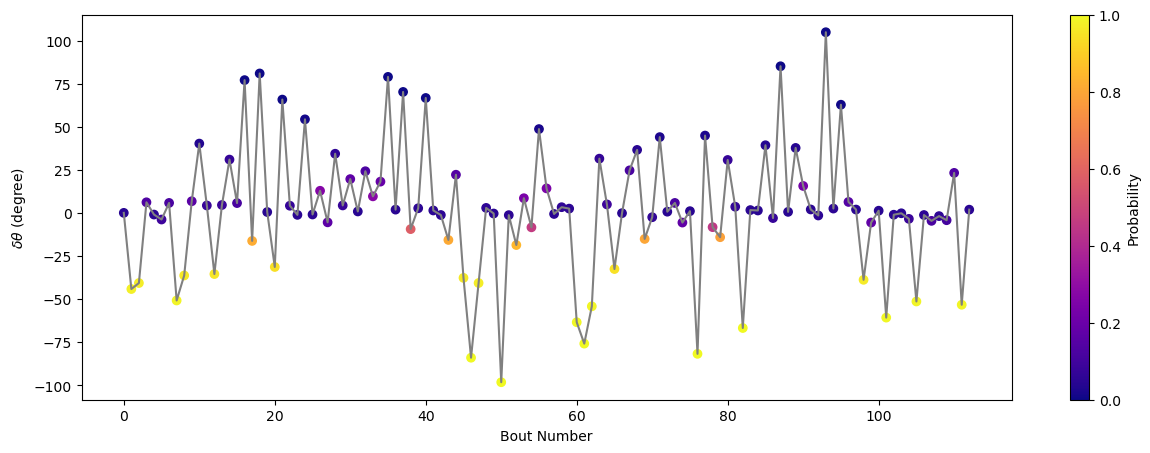

In [60]:
fig, ax = plt.subplots(figsize=(15,5))
plot_angle_sequence(ax, sequence, probas=proba_left)

According to you, how well does it work ?  
Try different sequences and look at the 'Forward' and 'Right' subpopulations.  
Is there a problem around the 'Forward' subpopulation ?

# 3. Hidden Markov Model

In section 1 we've seen how we can model the statistics of re-orientations angles $\delta \theta$s using a Markov Chain (MC). However, for this we had to first classify manualy the bouts into discrete states 'Forward', 'Left' and 'Right'.  
In section 2 we've seen that we can more or less model the re-orientations $\delta \theta$s by the mixture of 3 gaussians, one for each state.

In this last section, we will use Hidden Markov Models (HMMs) to once again model the re-orientation statistics of the larvae.

**A quick reminder about HMMs :**  
(❗ We will only talk about very simple 1D HMMs in this reminder.)  
A HMM works very similarly to a MC. It makes the assumption that the system can be in one of several discrete states, and has a transition matrix $T_{cn} = P(c→n)$ which defines how the system transitions from the current state to the next state.  
However, contrary to the MC which only deals with the discrete states, with HMMs, we concider that the states are hidden (hence the name 😜). Instead, a HMM has *emissions*. Each state $s$ is associated to a distribution $\mathcal{D}_s$. So when the system is in state $s=1$, we will observe values $x$ distributed according to $\mathcal{D}_1$, etc ... The correspondance between each state $s$ and its distribution $\mathcal{D}_s$ is stored in the emission matrix $E_s$.

**In our case :**
- we still want to model the re-orientation dynamics with the 3 states 'Forward', 'Left', and 'Right'.  
- what we observe are the re-orientations angles $\delta \theta$, and we've seen in section 2 that we can approximate them by 3 Normal distributions. Hence our 3 emissions will be $\mathcal{N}(\mu_F, \sigma_F)$, $\mathcal{N}(\mu_L, \sigma_L)$, and $\mathcal{N}(\mu_R, \sigma_R)$. 

As all emissions are gaussian, our HMM will be a subclass of HMMs called a GaussianHMM. The emission matrix is therefore simplified to a vector $\mu_s = [\mu_F, \mu_L, \mu_R]$ and a vector $\sigma_s = [\sigma_F, \sigma_L, \sigma_R]$, which together describe each emission distributions.

![HMM](https://raw.githubusercontent.com/EmeEmu/IBIO-Banyuls2023-Python/main/img/HMM.png)

First let's reload the data for 26°C.

In [61]:
data = file["/behaviour/26/"]
xs, ys = data["xpos"][:], data["ypos"]  # x and y positions 
dthetas = data["dtheta"][:]             # reorientation angles
dts = data["interboutintervals"][:]     # interbout intervals
distance = data["displacements"][:]     # distance traveled with each bout

## 3.1 Preparing the data

We will use the library [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) (imported at the top of this notebook as `hmm`) instead of programming our own HMMs.  
However for this, we first need to prepare our data in a format which will be understood by `hmm`.

The first step if to remove all the NaNs from $\delta \theta$ sequences, because `hmm` cannot work with NaNs.  
**➡️👤⌨️ Make a list called `sequences` containing all the $\delta \theta$ sequences in `dthetas`, but without the NaNs. And make a second list called `lenghts` containing the lenght (aka. number of bouts) for each sequence in `sequences`. ➡️👤⌨️**  

💡 You can use the function `np.isfinite` to identify where an array is not equal to NaN.

In [62]:
# ➡️👤⌨️
sequences = [seq[np.isfinite(seq)] for seq in dthetas]
lenghts = [len(seq) for seq in sequences]

➡️👤⌨️ Now **stitch all the sequences in `sequences` together as one 1D vector (this is called concatenation).** ➡️👤⌨️

💡 You can use the function `np.concatenate`.

In [64]:
# ➡️👤⌨️
long_seq = np.concatenate(sequences)
long_seq.ndim

1

## 3.2 Preparing the Model

Now we can build the HMM.  
We will provide the HMM with an initial guess of its parameters :
- the transition matrix $T_cn = P(c→n)$ between hidden states we computed from the MC : `T_bouts`.
- the *a priori* probability of each hidden state $P(s)$ we computed from the MC : `p_bouts`.
- gaussian emission means $\mu_s = [\mu_F, \mu_L, \mu_R] = [0,-30,+30]$.
- gaussian emission variance $\sigma_s^2 = [\sigma_F^2, \sigma_L^2, \sigma_R^2] = [11,700,700]$.

❗ If you had time to do section 2 on Gaussian Mixture Models, you can use the parameters of the 3 subpopulations you found for $\mu_s$ and $\sigma_s^2$.

In [108]:
model = hmm.GaussianHMM(
    n_components=3,                # the number of hidden states we want
    covariance_type="spherical",   # this is complicated, you can look at the doc if you want to understand
    init_params="",                # this is complicated, you can look at the doc if you want to understand
    algorithm='viterbi',           # the decoder algorithm
)

model.transmat_ = T_bouts
model.startprob_ = p_bouts
model.means_ = np.array([[0], [-30], [+30]])
model.covars_ = np.array([[11],[700],[700]])

## 3.3 Investigating the model

Now that our model is initiated, we can look at it in more detail.

❗ Remember that for now, our model still hasn't been trained. Its parameters are guesses.

First let's generate a very long sequence of bouts, and look at the distribution of $\delta \theta$.

In [109]:
gen_dthetas, gen_states = model.sample(10000)

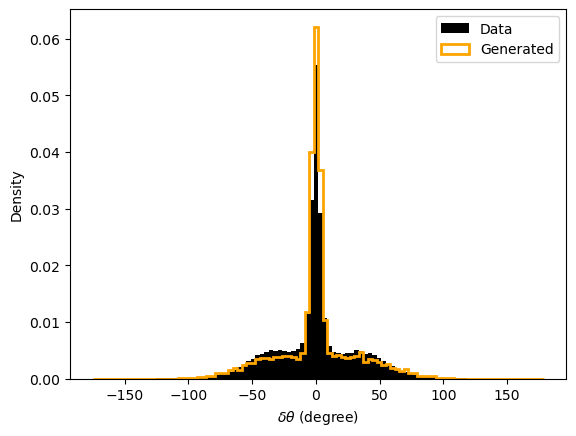

In [110]:
fig, ax = plt.subplots()
_,bins,_ = ax.hist(dthetas.ravel(), bins=100, color="k", density=True, label="Data");
ax.hist(
    gen_dthetas.ravel(), bins=bins, 
    color="orange", density=True, 
    histtype="step", label="Generated",
    linewidth=2,
);
ax.set_xlabel(r"$\delta \theta$ (degree)")
ax.set_ylabel("Density")
ax.legend()

Are the data and generated distributions the same ? Why do you think that is ?

Let's look at the transition matrix and *a priori* state proabilities : 

Text(0.5, 1.0, 'P(s)')

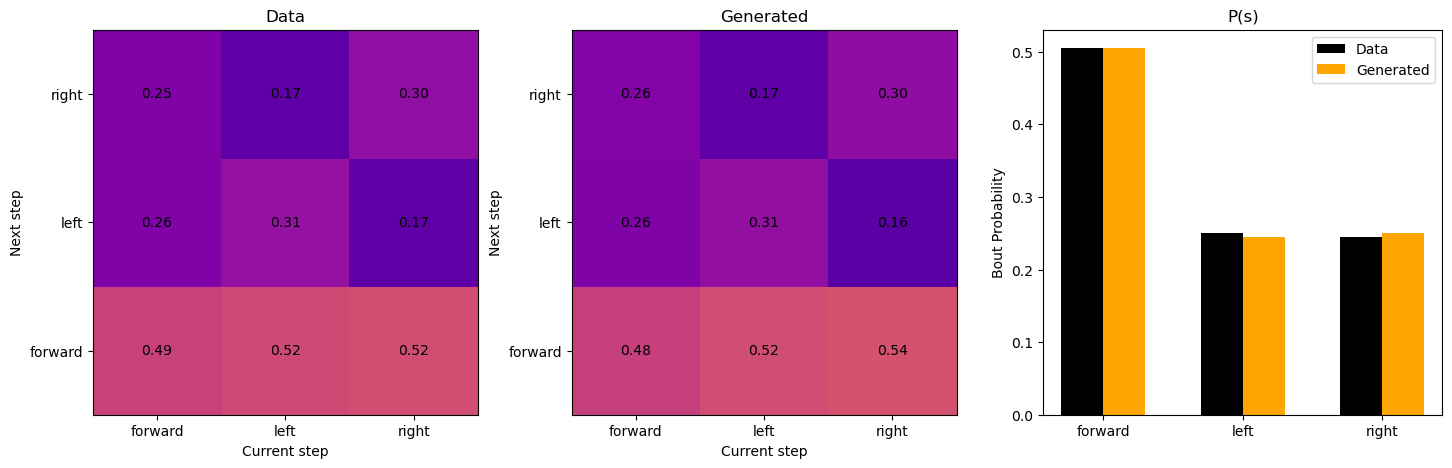

In [111]:
fig, axs = plt.subplots(ncols=3, figsize=(3.5*5,5))
plot_transition_matrix(axs[0], T_bouts)
axs[0].set_title("Data")
plot_transition_matrix(axs[1], bout_transition([gen_states]))
axs[1].set_title("Generated")
ax = axs[2]
width = 0.3
x = np.arange(3)
ax.bar(x-width/2, p_bouts, width, label="Data", color="k")
ax.bar(x+width/2, bout_proba(gen_states), width, label="Generated", color="orange")
ax.legend()
ax.set_xticks([0,1,2], ["forward", "left", "right"])
ax.set_ylabel("Bout Probability")
ax.set_title(r"P(s)")

Again, are data and generated the same ? Why do you think that is ?

We can also look at the Stationary Distribution, $\mu_s$ and $\sigma_s^2$, which at this stage should not be surprising.

In [112]:
model.get_stationary_distribution()

array([0.50371241, 0.25085664, 0.24543095])

In [113]:
model.means_

array([[  0],
       [-30],
       [ 30]])

In [114]:
model.covars_

array([[[ 11.]],

       [[700.]],

       [[700.]]])

Similarly to what we did in section 2, we can ask the model to predict the hidden state given a observation.  

➡️👤⌨️ **Predict the states for one of the sequences in `sequences`.** ➡️👤⌨️

💡 you can use the function `model.predict`.  
💡 `model.predict` expects a 2D array, you can use `np.newaxis` to solve that problem.

In [115]:
# ➡️👤⌨️
sequence = sequences[1]
predicted_states = model.predict(sequence[:,np.newaxis])

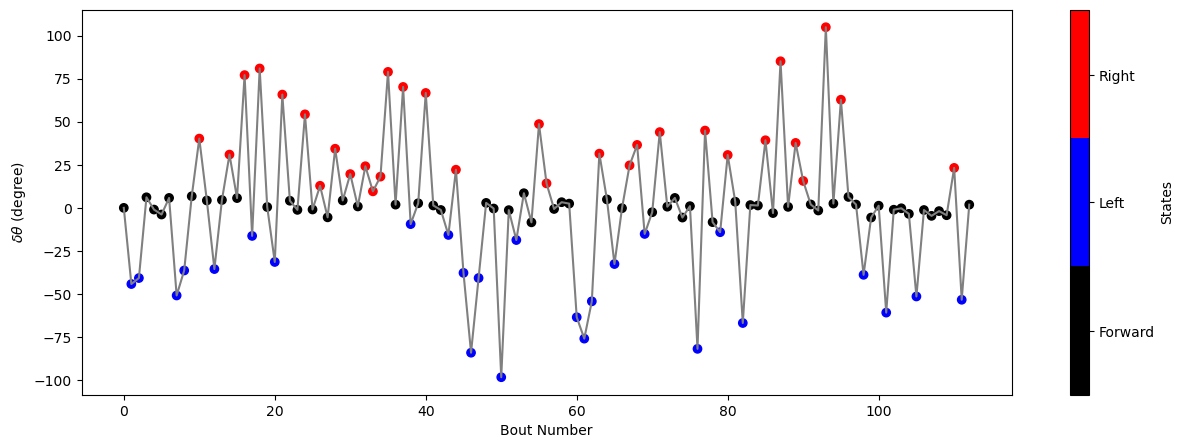

In [116]:
fig, ax = plt.subplots(figsize=(15,5))
plot_angle_sequence(ax, sequence, states=predicted_states)

Under the hood, `model.predict` predicts the state $s_i$ of observation $\delta \theta_i$, by computing the probability that $s_i$ is observed in each of the 3 hidden states : $P(\delta \theta_i | F)$, $P(\delta \theta_i | L)$ and $P(\delta \theta_i | R)$. This is done using the [Viterbi Algorithm](https://en.wikipedia.org/wiki/Viterbi_algorithm). The state for which this probability is maximum becomes the predicted state : $$s_i = \max_{s\in {F,L,R}} P(\delta \theta_i | s)$$

➡️👤⌨️ **Find the probability that each observation in `sequence` is in state 'Forward'.** ➡️👤⌨️

💡 you can use the function `model.predict_proba`.

In [117]:
# ➡️👤⌨️
predicted_forward = model.predict_proba(sequence[:,np.newaxis])[:,0]

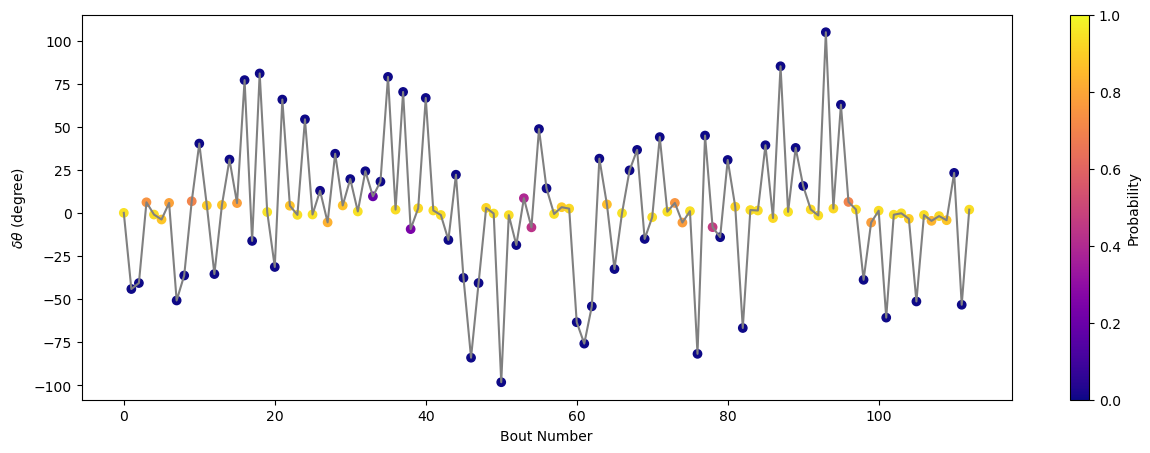

In [118]:
fig, ax = plt.subplots(figsize=(15,5))
plot_angle_sequence(ax, sequence, probas=predicted_forward)

## 3.4 Generating sequences

As with Markov Chains, we can generate sequences of states by sampling the transition matrix. The difference with HMMs is that we can also generate observed emissions.

In this section we will investigate how realistic are the re-orientations sequences generated by the HMM.  

➡️👤⌨️ **Generate sequences of $\delta \theta$s with the following constraints :** ➡️👤⌨️ 
- you should generate the same number of sequences as are found in `sequences`
- the generated sequences should have lenghts distributed similarly to the ones found in `sequences`
- store the generated $\delta \theta$s and state sequences in lists, similarly to `sequences`

💡 to generate you can use the function `model.sample`  
⚠️ `model.sample` will output a 2D array. You only want a 1D vector.

In [140]:
# ➡️👤⌨️
gen_dthetas, gen_states = [],[]
for _ in tqdm(sequences):
    l = np.random.choice(lenghts)
    gt, gs = model.sample(l)
    gen_dthetas.append(gt[:,0])
    gen_states.append(gs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1513/1513 [00:11<00:00, 129.51it/s]


Let's look at one of the generated sequence. (change `i` to look at different sequences)
Does it look similar to the orignal data ?  
According to you, are the states classified correctly ? Why do you think that is ?

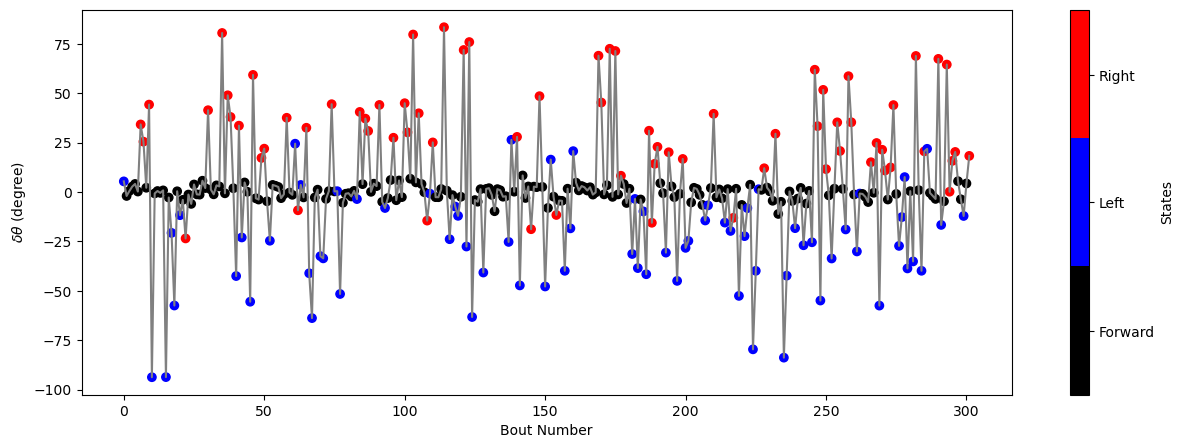

In [123]:
i = 3
fig, ax = plt.subplots(figsize=(15,5))
plot_angle_sequence(ax, gen_dthetas[i], states=gen_states[i])

To make it a bit more intuitive, we can reconstruct fake $(x,y)$ larvae trajectories from the generated $\delta \theta$ and by sampling from the `distance` distribution (aka. how far the larva moves during each bout). This will not recreate perfectly realistic trajectories, but will provide a rough estimate.

❗ If you have enough time, and feel up to the challenge, you can try to code the function yourself. But warning! , it is a bit hard.

In [124]:
def reconstruct_trajs(dthets):
    """Reconstruct (x,y) trajectory from a sequencere-orientation angles.
    
    Parameters :
    ------------
    dthets : 1d array
        sequence of re-orientation angles

    Return :
    --------
    x : 1d array
        reconstructed x positions
    y : 1d array
        reconstructed y positions
    """
    angles = np.cumsum(-np.deg2rad(dthets))
    dists = np.random.choice(distance[np.isfinite(distance)], size=len(dthets))
    dxy =  dists[:,np.newaxis]* np.c_[np.cos(angles), np.sin(angles)]
    x,y = tuple(np.cumsum(dxy, axis=0).T)
    return x, y

Let's apply it to a generated trajectory.  
❗ you can run the next cell a few times, with the same sequence `i`, and different sequences, to build a better intuition.

Does this trajectory look relalistic to you ?  
Does it look like the other trajectories at 26°C ?

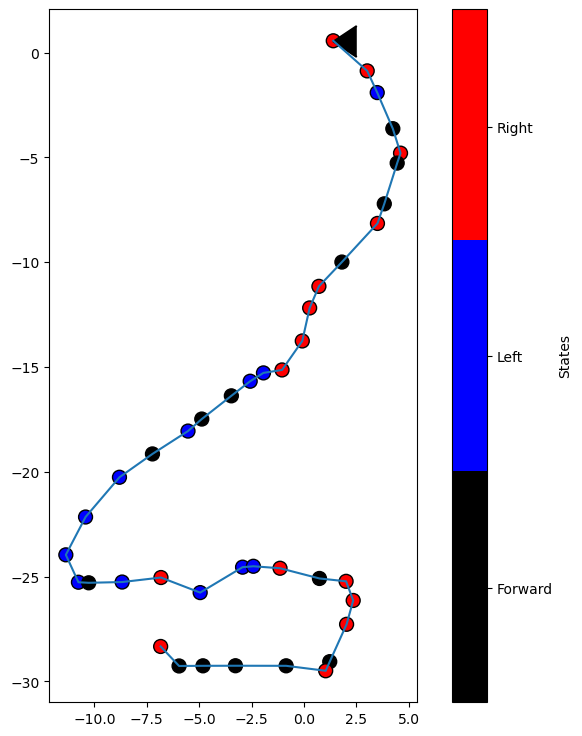

In [128]:
i = 1
gen_x, gen_y = reconstruct_trajs(gen_dthetas[i])

fig, ax = plt.subplots(figsize=(9,9))
ax.plot(gen_x,gen_y)
h = ax.scatter(
    gen_x, 
    gen_y, 
    c=np.insert(gen_states[i][1:], -1,0), 
    cmap=cmap_states, edgecolors="k", s=100
)
ax.scatter(gen_x[0], gen_y[0], marker=4, s=500, color="k")
cbar = fig.colorbar(h, ax=ax)
cbar.set_label("States")
cbar.set_ticks([0.33, 1, 1.66], labels=["Forward", "Left", "Right"])
ax.set_aspect("equal")

## 3.5 Mean Square Reorientation

As we have said before, Markov Chains (and therefore Hidden Markov Models) are memory-less systems. The next step only depends on the current step. Therefore they only model very short-term dynamics, and might completly miss the long-term dynamics present in the data. In fact, if a system can be perfectly modeled with a MC or HMM, then it is a very strong clue that this system has no memory, and we call them *markovian*.

But how do we check if our HMM model reproduces long-term dynamics of re-orientations ?

One thing we can look at is the **Mean Square Reorientation** (MSR).  
MSR is a measurment of how much your direction changes compared to your initial direction, but taking the initial direction anywhere on your trajectory. Let's say that again but differently. You will have $M_q$ the measurement of how much your angle has changes on average when you make $q$ bouts (this is called the lag). This is calculated by averaging over all bouts in the trajectory.
$$\begin{split}
M_q &= \Biggl \langle  (\theta_{n+q} - \theta_{n})^2  \Biggr \rangle_{n}\\
    &= \Biggl \langle  \left(\sum_{i=0}^{q-1} \delta \theta_{n+i} \right)^2  \Biggr \rangle_{n}\\
    &= \frac{1}{N-q+1} \sum_{n=0}^{N-q} \left(\sum_{i=0}^{q-1} \delta \theta_{n+i} \right)^2
\end{split}$$
with $N$ the number of bouts in a trajectory.

➡️👤⌨️ **Implement this function $M_q$.** ➡️👤⌨️

In [129]:
def MSR_q(seq, q):
    """Compute the Mean Squared Reorientation of a sequence.
    
    Parameters : 
    ------------
    seq : 1D array of floats
        sequences of re-orientations angles.
    q : integer
        the lag.

    Return :
    --------
    m_q : float
        the computed M_q (see math function above)
    """
    assert seq.ndim==1, ":seq: should be a 1D vector."

    # ➡️👤⌨️
    b = []
    for n in range(len(seq)-q+1):
        a = 0
        for i in range(q):
            a += seq[n+i]
        b.append(a**2)
    m_q = np.mean(b)
    # ➡️👤⌨️

    assert "float" in str(type(m_q)), ":m_q: should be a float."
    return m_q

Now, when we look at MSR, we are interested in more than just 1 value of lag $q$.  
➡️👤⌨️ **Write a function to compute the MSR for multiple values of $q$.** ➡️👤⌨️

In [130]:
def MSR(seq, qs):
    """Compute the MSR of a sequence at multiple lags.
    
    Parameters : 
    ------------
    seq : 1D array of floats
        sequences of re-orientations angles.
    qs : 1D array of integers
        the lags.

    Return :
    --------
    m_qs : 1D array
        the computed M_q's (see math function above)
    """
    assert seq.ndim==1, ":seq: should be a 1D vector."
    
    # ➡️👤⌨️
    m_qs = np.empty_like(qs, dtype=np.float_)
    for i,q in enumerate(qs):
        m_qs[i] = MSR_q(seq, q)
    # ➡️👤⌨️

    assert m_qs.ndim==1, ":m_qs: should be a 1D vector."
    assert len(m_qs)==len(qs), ":m_qs: should have the same lenght as :qs:."
    return m_qs

Now lets compute MSR for all sequences, over large range of lags $q \in (0,15)$.  
We will then compute the mean MSR over the sequences, and the standard error of the mean. And then plot the results.

In [131]:
qs = np.arange(0,15)
MSRS = np.empty((len(sequences),len(qs)), dtype=np.float_)
for i in tqdm(range(len(sequences))):
    MSRS[i] = MSR(sequences[i], qs)

  1%|██▏                                                                                                                                                  | 22/1513 [00:00<00:06, 218.55it/s]/home/mkk/.conda/envs/ibio/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mkk/.conda/envs/ibio/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1513/1513 [00:02<00:00, 541.05it/s]


In [132]:
MSR_mean = np.nanmean(MSRS, axis=0) 
MSR_std = np.nanstd(MSRS, axis=0)/ np.sqrt(MSRS.shape[0])

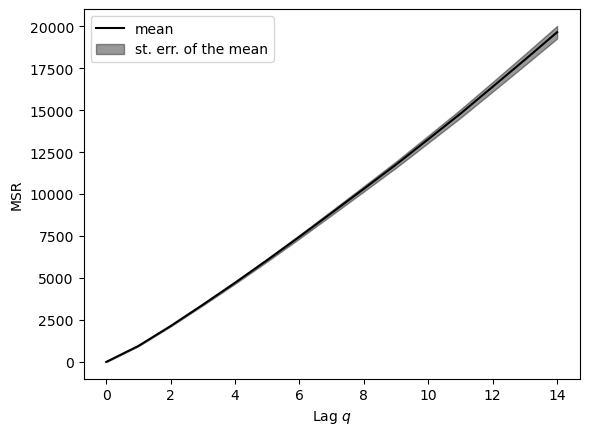

In [133]:
fig, ax = plt.subplots()
ax.plot(qs, MSR_mean, color="k", label="mean")
ax.fill_between(qs, MSR_mean-MSR_std, MSR_mean+MSR_std, alpha=0.4, color="k", label="st. err. of the mean")
ax.set_xlabel("Lag $q$")
ax.set_ylabel("MSR")
ax.legend()

This can be a bit hard to interpret if you are not used to MSR curve. So lets find something to compare this curve with.

Imagine if there was no structure in the reorientation angles, and the larvae would choose randomely the $\delta \theta$. What would that look like ?

To generate this fake/random sequences, we will just choose random re-orientation from the distribution of $\delta \theta$s, this way, the probability of each $\delta \theta$ will stay the same but we will loose all the temporal structure.

In [134]:
rand_seq = np.random.choice(long_seq, size=(len(sequences),np.mean(lenghts).astype(int)))
MSR_rand = np.empty((len(sequences),len(qs)), dtype=np.float_)
for i in tqdm(range(len(sequences))):
    MSR_rand[i] = MSR(rand_seq[i], qs)
MSR_rand_mean = np.nanmean(MSR_rand, axis=0) 
MSR_rand_std = np.nanstd(MSR_rand, axis=0)/ np.sqrt(MSR_rand.shape[0])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1513/1513 [00:02<00:00, 563.92it/s]


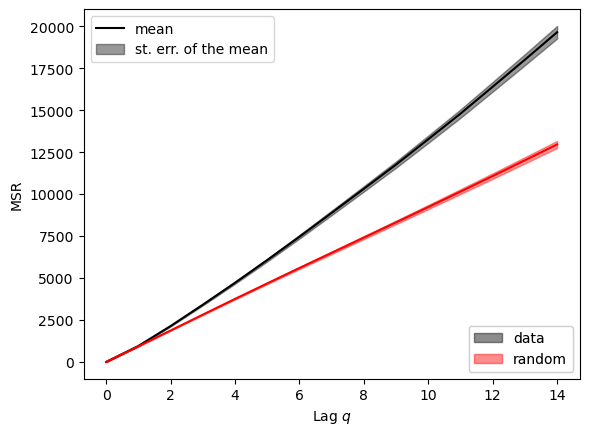

In [135]:
fig, ax = plt.subplots()

a_dat = ax.plot(qs, MSR_mean, color="k")
h_dat = ax.fill_between(qs, MSR_mean-MSR_std, MSR_mean+MSR_std, alpha=0.4, color="k")
ax.plot(qs, MSR_rand_mean, color="red")
h_rand = ax.fill_between(qs, MSR_rand_mean-MSR_rand_std, MSR_rand_mean+MSR_rand_std, alpha=0.4, color="red")

ax.set_xlabel("Lag $q$")
ax.set_ylabel("MSR")
leg1 = plt.legend([a_dat[0], h_dat], ["mean", "st. err. of the mean"], loc="upper left")
leg2 = plt.legend([h_dat, h_rand], ["data", "random"], loc="lower right")
ax.add_artist(leg1)
ax.add_artist(leg2);

How can you interpret this graph ?

Now let's build the MSR curve for the data generated from the HMM.

In [141]:
MSR_hmm = np.empty((len(sequences),len(qs)), dtype=np.float_)
for i in tqdm(range(len(sequences))):
    MSR_hmm[i] = MSR(gen_dthetas[i], qs)
MSR_hmm_mean = np.nanmean(MSR_hmm, axis=0) 
MSR_hmm_std = np.nanstd(MSR_hmm, axis=0)/ np.sqrt(MSR_hmm.shape[0])

  0%|                                                                                                                                                               | 0/1513 [00:00<?, ?it/s]/home/mkk/.conda/envs/ibio/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mkk/.conda/envs/ibio/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1513/1513 [00:02<00:00, 550.07it/s]


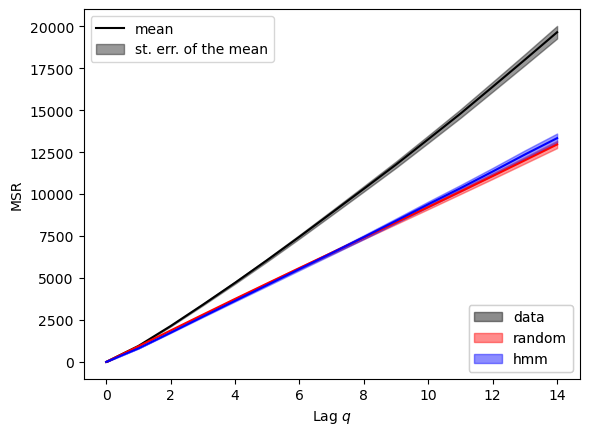

In [137]:
fig, ax = plt.subplots()

a_dat = ax.plot(qs, MSR_mean, color="k")
h_dat = ax.fill_between(qs, MSR_mean-MSR_std, MSR_mean+MSR_std, alpha=0.4, color="k")
ax.plot(qs, MSR_rand_mean, color="red")
h_rand = ax.fill_between(qs, MSR_rand_mean-MSR_rand_std, MSR_rand_mean+MSR_rand_std, alpha=0.4, color="red")
ax.plot(qs, MSR_hmm_mean, color="blue")
h_hmm = ax.fill_between(qs, MSR_hmm_mean-MSR_hmm_std, MSR_hmm_mean+MSR_hmm_std, alpha=0.4, color="blue")

ax.set_xlabel("Lag $q$")
ax.set_ylabel("MSR")
leg1 = plt.legend([a_dat[0], h_dat], ["mean", "st. err. of the mean"], loc="upper left")
leg2 = plt.legend([h_dat, h_rand, h_hmm], ["data", "random", "hmm"], loc="lower right")
ax.add_artist(leg1)
ax.add_artist(leg2);

What can you conclude ? Is the HMM better than random ? Equivalent to the data ? If not, can you interpret what is the difference ?

## 3.6 Training HMMs

Until now we have worked with an HMM intitialised with parameters which were only guesses.  
However, most of the time, we prefer to fit them on the data, starting from an initial guess.

This can be done very easily with the following code.

In [139]:
model.fit(long_seq[:,np.newaxis], lenghts)

GaussianHMM(covariance_type='spherical', init_params='', n_components=3)

By learning directly from the data, the fiting algorithm modified the $T_{cn}$, $\mu_s$, and $\sigma_s^2$.  
➡️👤⌨️ **Re-run the cells in sections 3.3 to 3.5 to see what changed.** ➡️👤⌨️

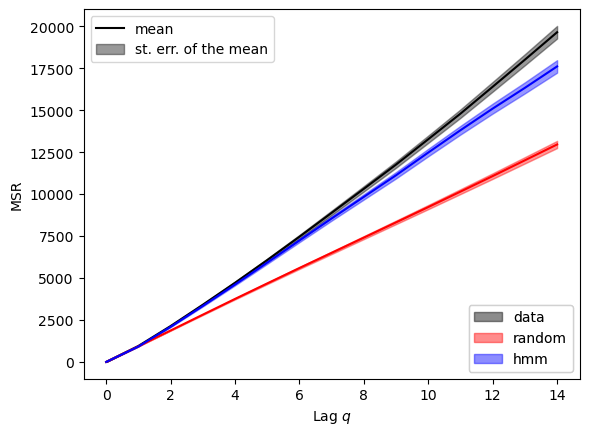

In [142]:
fig, ax = plt.subplots()

a_dat = ax.plot(qs, MSR_mean, color="k")
h_dat = ax.fill_between(qs, MSR_mean-MSR_std, MSR_mean+MSR_std, alpha=0.4, color="k")
ax.plot(qs, MSR_rand_mean, color="red")
h_rand = ax.fill_between(qs, MSR_rand_mean-MSR_rand_std, MSR_rand_mean+MSR_rand_std, alpha=0.4, color="red")
ax.plot(qs, MSR_hmm_mean, color="blue")
h_hmm = ax.fill_between(qs, MSR_hmm_mean-MSR_hmm_std, MSR_hmm_mean+MSR_hmm_std, alpha=0.4, color="blue")

ax.set_xlabel("Lag $q$")
ax.set_ylabel("MSR")
leg1 = plt.legend([a_dat[0], h_dat], ["mean", "st. err. of the mean"], loc="upper left")
leg2 = plt.legend([h_dat, h_rand, h_hmm], ["data", "random", "hmm"], loc="lower right")
ax.add_artist(leg1)
ax.add_artist(leg2);